In [17]:
import numpy as np
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import cell2location
import scvi

In [18]:
pos_ss = np.load('/Volumes/Conerstone/github/SGE/data/snRNASeq/melanoma_semi_syn_pos.npy')
snRNA_label_path = '/Volumes/Conerstone/github/SGE/data/snRNASeq/snRNA_annotation_astro_subtypes_refined59_20200823.csv'
snRNA_reads_path = '/Volumes/Conerstone/github/SGE/data/snRNASeq/all_cells_20200625.h5ad'
adata_snrna_raw = anndata.read_h5ad(snRNA_reads_path)
labels = pd.read_csv(snRNA_label_path, index_col=0)
labels = labels.reindex(index=adata_snrna_raw.obs_names)
adata_snrna_raw.obs[labels.columns] = labels
# load the spatial layout and the truth prior
path = '/Users/hrzhang/Dropbox/jac/'
pos = np.load(path+'semisyn_3_pos.npy')
Truth_prior = np.load(path+'semi_syn_melanoma_3_Truth_prior.npy')
Truth_ncells = np.load(path+'semi_syn_melanoma_3_Truth_ncells.npy')
Truth_reads = np.load(path+'semi_syn_melanoma_3_Truth_reads.npy')
Observation = Truth_reads.sum(axis=-1).astype(int)
n_genes=300
# get the scRNA reads
gene_count_mat = adata_snrna_raw.X.A
# get the cell type
# TODO: needs to change "cell_type_toselect" to modify the scRNA reference you want to pass in
cell_types = adata_snrna_raw.obs['annotation_1']
cell_type_toselect = ['Ext_L56', 'Ext_Thal_1', 'Inh_Lamp5']
# cell_type_toselect = np.unique(lables)
cell_type_filter = cell_types.isin(cell_type_toselect) # boolean indicator: if a entry in the raw scRNA is selected
cell_types = cell_types[cell_type_filter] # cell type vector for all selected scRNA samples

gene_count_mat = np.asarray(adata_snrna_raw.X[cell_type_filter].todense())
top = np.argsort(np.std(np.log(1+gene_count_mat), axis=0))[::-1]
# set up the scRNA reference with 300 genes
sc_anndata = adata_snrna_raw[cell_type_filter, top[:n_genes]]

In [34]:
sc_anndata = anndata.read_h5ad('../Condor/bayestme/sc_ref/reference_3.h5ad')

In [ ]:
sc_anndata.write('../Condor/bayestme/sc_ref/reference_3.h5ad')

In [19]:
sc_anndata = anndata.read_h5ad('../Condor/bayestme/sc_ref/reference_3.h5ad')

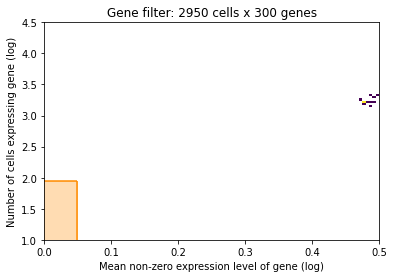

In [20]:
# filter gene (you dont't need to worry about this)
from cell2location.utils.filtering import filter_genes
selected = filter_genes(sc_anndata, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

In [21]:
cell2location.models.RegressionModel.setup_anndata(adata=sc_anndata,
                        # 10X reaction / sample / batch
                        batch_key='sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='annotation_1',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=None
                       )

Anndata setup with scvi-tools version 0.16.2.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': 'annotation_1',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 2950  │
│          n_vars          │  300  │
│         n_batch          │   6   │
│         n_labels         │   3   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃   Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ 5705STDY8058280 │          0          │
│                     │ 5705STDY8058281 │          1          │
│                     │ 5705STDY8058282 │          2          │
│                     │ 5705STDY8058283 │          3          │
│                     │ 5705STDY8058284 │          4          │
│                     │ 5705STDY8058285 │          5          │
└─────────────────────┴─────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['annotation_1'] │  Ext_L56   │          0          │
│                           │ Ext_Thal_1 │          1          │
│                           │ Inh_Lamp5  │          2          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/hrzhang/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/Users/hrzhang/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Sampling global variables, sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:06<00:00, 162.40it/s]


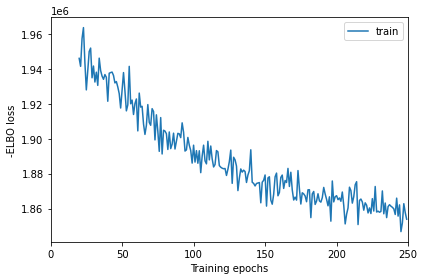

In [22]:
from cell2location.models import RegressionModel
mod = RegressionModel(sc_anndata)
cell2location.models.RegressionModel.view_anndata_setup(mod)
mod.train(max_epochs=250, batch_size=2500, train_size=1, lr=0.002, use_gpu=False)
mod.plot_history(20)
sc_adata = mod.export_posterior(
    sc_anndata, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': False}
)

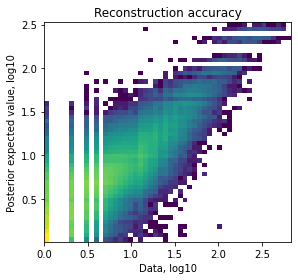

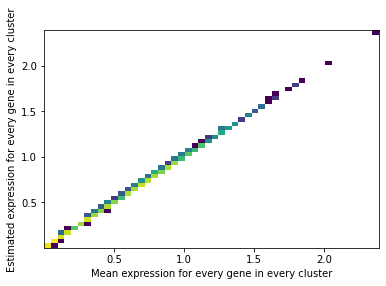

In [23]:
mod.plot_QC()

In [24]:
from scipy.sparse import csr_matrix
# num of spots
n_nodes = pos.shape[1]

# prepare the ST data
st_anndata = anndata.AnnData(X=csr_matrix(Observation))
# set spatial barcodes (borrowed from V1_Human_Lymph_Node)
adata_vis = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node") # the warning comes from here, no need to worry
obs_index = adata_vis.obs.index[:n_nodes]
st_anndata.obs.index = obs_index
# set the in-tissue indicator
st_anndata.obs['in_tissue'] = adata_vis.obs['in_tissue'][:n_nodes]

# set the spot coordinates
st_anndata.obsm['spatial'] = pos.T
array_row = pd.Series(pos[1])
array_row.index = obs_index
array_row.name = 'array_row'
array_col = pd.Series(pos[0])
array_col.index = obs_index
array_col.name = 'array_col'
st_anndata.obs['array_row'] = array_row
st_anndata.obs['array_col'] = array_col
var_index = sc_anndata.var_names
st_anndata.var.index = var_index
# set some other parameters
st_anndata.var['gene_ids'] = var_index
st_anndata.var['feature_types'] = sc_anndata.var['feature_types'].astype(object)
st_anndata.var['genome'] = sc_anndata.var['genome'].astype(object)
st_anndata.obs['sample'] = 'semisynthetic'

/var/folders/41/wxyyz25j4m324br78sjcqf5w0000gn/T/ipykernel_45320/3341446560.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  st_anndata = anndata.AnnData(X=csr_matrix(Observation))
/Users/hrzhang/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
from scipy.sparse import csr_matrix
# num of spots
n_nodes = pos.shape[1]

# prepare the ST data
st_anndata = anndata.AnnData(X=csr_matrix(Observation))
# set spatial barcodes (borrowed from V1_Human_Lymph_Node)
adata_vis = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node") # the warning comes from here, no need to worry
obs_index = adata_vis.obs.index[:n_nodes]
st_anndata.obs.index = obs_index
# set the in-tissue indicator
st_anndata.obs['in_tissue'] = adata_vis.obs['in_tissue'][:n_nodes]

# set the spot coordinates
st_anndata.obsm['location'] = pos.T
array_row = pd.Series(pos[1])
array_row.index = obs_index
array_row.name = 'array_row'
array_col = pd.Series(pos[0])
array_col.index = obs_index
array_col.name = 'array_col'
st_anndata.obs['array_row'] = array_row
st_anndata.obs['array_col'] = array_col
var_index = sc_anndata.var_names
st_anndata.var.index = var_index

st_anndata.obs["n_counts"] = np.sum(st_anndata.X, axis=1)
st_anndata.layers["counts"] = st_anndata.X.copy()
st_anndata.obsm['spatial'] = st_anndata.obsm['location']

sc.pp.normalize_total(st_anndata, target_sum=10e4)
sc.pp.log1p(st_anndata)
st_anndata.raw = st_anndata

In [25]:
st_anndata.write('../Condor/bayestme/sc_ref/observation_3.h5ad')

In [26]:
st_anndata = anndata.read_h5ad('../Condor/bayestme/sc_ref/observation_3.h5ad')

In [27]:
# get the gene shown both in scRNA and ST (in our case, this is trivial)
inf_aver = sc_adata.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in sc_adata.uns['mod']['factor_names']]].copy()
inf_aver.columns = sc_adata.uns['mod']['factor_names']

intersect = np.intersect1d(st_anndata.var_names, inf_aver.index)
adata_vis = st_anndata[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

Anndata setup with scvi-tools version 0.16.2.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │  279  │
│          n_vars          │  300  │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                    batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ semisynthetic │          0          │
└─────────────────────┴───────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/hrzhang/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/Users/hrzhang/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 30000/30000: 100%|████████████████████████████████████████████████████████████████████████████████| 30000/30000 [17:26<00:00, 28.66it/s, v_num=1, elbo_train=3.52e+5]


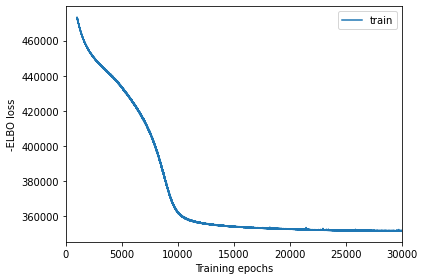

In [28]:
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    # the expected average cell abundance: tissue-dependent 
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=60,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=200
) 
cell2location.models.Cell2location.view_anndata_setup(mod)
mod.train(max_epochs=30000, 
          # train using full data (batch_size=None)
          batch_size=None, 
          # use all data points in training because 
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=False)
mod.plot_history(1000)

In [29]:
import matplotlib.pyplot as plt

In [30]:
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': False}
)
n_cells = adata_vis.obsm['q05_cell_abundance_w_sf'].values
post_mean = adata_vis.obsm['means_cell_abundance_w_sf'].values

Sampling global variables, sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:08<00:00, 115.17it/s]


In [33]:
adata_vis.obsm['q05_cell_abundance_w_sf']

,q05cell_abundance_w_sf_Ext_L56,q05cell_abundance_w_sf_Ext_Thal_1,q05cell_abundance_w_sf_Inh_Lamp5
AAACAAGTATCTCCCA-1,0.001019,1.385799,40.259590
AAACAATCTACTAGCA-1,0.000898,0.000270,46.305261
AAACACCAATAACTGC-1,0.156835,0.034123,45.018355
AAACAGAGCGACTCCT-1,0.006653,0.003070,32.200903
AAACAGCTTTCAGAAG-1,0.920905,1.003896,33.672333
...,...,...,...
ACACCCGAGAAATCCG-1,21.342873,8.868785,28.898123
ACACCGGTCTGACCGC-1,27.814887,5.780519,26.024995
ACACCTTAAGTAGGGC-1,21.100718,2.071365,15.001757
ACACCTTACTACTTGC-1,32.028961,1.123367,16.121512


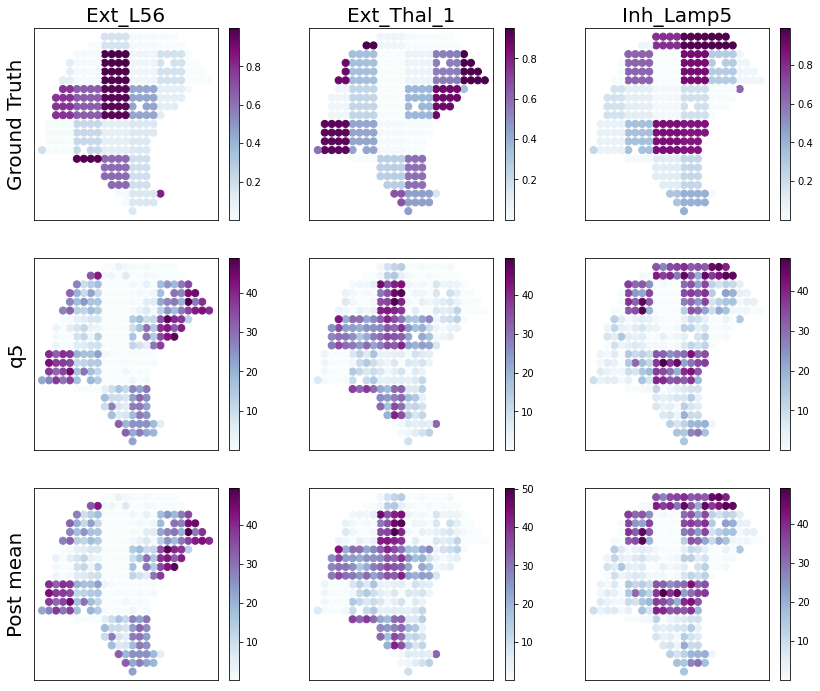

In [32]:
import SGE.python.plot_st_data as st_plt
# post_prob = st_anndata.obsm["proportions"].values
cell_name = cell_type_toselect
reorder = [0, 1, 2] # you may want to change this order vector to make the prediction aligned with the ground truth
n_components = n_cells.shape[-1]
fig, ax = plt.subplots(3, n_components, figsize=(4*n_components+2, 12))
for k in range(n_components):
    im = st_plt.plot_spots(ax[0, k], Truth_prior[:, k], pos[::-1], s=50, cmap='BuPu')
    plt.colorbar(im, ax=ax[0, k])
    ax[0, k].set_xticks([])
    ax[0, k].set_yticks([])
    ax[0, k].set_title(cell_name[k], fontsize=20)
    im = st_plt.plot_spots(ax[1, k], n_cells[:, reorder[k]], pos[::-1], s=50, cmap='BuPu')
    plt.colorbar(im, ax=ax[1, k])
    ax[1, k].set_xticks([])
    ax[1, k].set_yticks([])
    im = st_plt.plot_spots(ax[2, k], post_mean[:, reorder[k]], pos[::-1], s=50, cmap='BuPu')
    plt.colorbar(im, ax=ax[2, k])
    ax[2, k].set_xticks([])
    ax[2, k].set_yticks([])
ax[0, 0].set_ylabel('Ground Truth', fontsize=20)
ax[1, 0].set_ylabel('q5', fontsize=20)
ax[2, 0].set_ylabel('Post mean', fontsize=20)

plt.show()